
# PPO for Mujoco

This is a reduced version of PPO as used for MuJoCO (at least how I understand it).

This means:
- use of GAE($\lambda$)
- collection of many time steps, even if it means that several episodes are collected
- Clip objective

Additionally: 
- counting time-steps rather than episodes
- one set of hyper-parameters for all environments

By my interpretation, several pieces of the full PPO algorithm are not used for MuJoCo (e.g., see Table 3 on page 10 of [the PPO paper](https://arxiv.org/abs/1707.06347)):
- no mention of more than one actor
- no mention of use of KL divergence or adaptive KL step-size, or entropy bonus, in the best result (see Table 1, and compare hyper-parameter settings for Roboschool and Atari, Tables 4 and 5, where there is mention of these approaches, but not for MuJoCo)

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RescaleAction

import numpy as np

import torch
from torch import nn

from torchrl.modules import TruncatedNormal # continous bounded action space

import copy # to save the old policy
import random # sample losses

In [2]:
# The policy needs to be modified to return a mean tensor and a standard deviations tensor
# - use logits as mean
# - standard deviations separate
# - no dependencies between dimensions of multi-variate normal distribution
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, n_out),
        )
        # self.sm = nn.Softmax(dim=0) # probabilities to choose an action
        # self.lsm = nn.LogSoftmax(dim=0) # for log probabilities used in the gradient for REINFORCE

        # From PPO, page 6: 
        # "To represent the policy, we used a fully-connected MLP with two hidden layers of 64 units,
        # and tanh nonlinearities, outputting the mean of a Gaussian distribution, with variable standard
        # deviations, following [Sch+15b; Dua+16]."
        # (See [Sch+15b] (Trust Region Policy Optimization) on page 15.)
        # Initialization of the standard deviations is not fully clear here, 
        # but to initialize them to 1 seems a reasonable first guess.
        self.log_stddevs = nn.Parameter(torch.zeros(n_out))
    
    def forward(self, x):
        logits = self.net(x)
        # probs = self.sm(logits)
        # scores = self.lsm(logits)
        # return probs, scores, logits # we include the logits in the output for use in the state-value function
        stddevs = torch.exp(self.log_stddevs)
        return logits, stddevs
    
class Value(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, 1), # same as Policy, but output is only one number
        )
    
    def forward(self, x): 
        logit = self.net(x)
        return logit

In [ ]:
envs = [
    "InvertedPendulum-v5",
    "InvertedDoublePendulum-v5",
    "Reacher-v5",
    "HalfCheetah-v5",
    "Hopper-v5",
    "Walker2d-v5",
    "Swimmer-v5"
]
from gymnasium.wrappers import RescaleAction
for env_name in envs:
    env = gym.make(env_name)
    wrapped_env = RescaleAction(env, min_action=-1, max_action=1)
    wrapped_env.reset()
    print("\nEnv name: {}, \n- Observation space: {} \n- Action space:      {} \n- Reward threshold: {}".format(env_name, wrapped_env.observation_space, wrapped_env.action_space, env.spec.reward_threshold))


Env name: InvertedPendulum-v5, 
- Observation space: Box(-inf, inf, (4,), float64) 
- Action space:      Box(-1.0, 1.0, (1,), float32) 
- Reward threshold: 950.0

Env name: InvertedDoublePendulum-v5, 
- Observation space: Box(-inf, inf, (9,), float64) 
- Action space:      Box(-1.0, 1.0, (1,), float32) 
- Reward threshold: 9100.0

Env name: Reacher-v5, 
- Observation space: Box(-inf, inf, (10,), float64) 
- Action space:      Box(-1.0, 1.0, (2,), float32) 
- Reward threshold: -3.75

Env name: HalfCheetah-v5, 
- Observation space: Box(-inf, inf, (17,), float64) 
- Action space:      Box(-1.0, 1.0, (6,), float32) 
- Reward threshold: 4800.0

Env name: Hopper-v5, 
- Observation space: Box(-inf, inf, (11,), float64) 
- Action space:      Box(-1.0, 1.0, (3,), float32) 
- Reward threshold: 3800.0

Env name: Walker2d-v5, 
- Observation space: Box(-inf, inf, (17,), float64) 
- Action space:      Box(-1.0, 1.0, (6,), float32) 
- Reward threshold: None

Env name: Swimmer-v5, 
- Observation spac

In [ ]:
seed = 42
env_name = "InvertedDoublePendulum-v5"

n_hidden1 = 64 
n_hidden2 = 64

gamma = 0.99
gae_lambda = 0.95 # New parameter for GAE

eps = 0.2 # New clipping parameter

# Sutton & Barto use a separate learning rate to update the state-value function parameters
# PPO has the same learning rate for both policy and value function
alpha = 3e-4

n_steps = 100 # TODO this should be reinterpreted as total number of interactions with the environment
T = 128 # 2048
n_epochs = 1 # 10
minibatch_size = 128 # 64

print_every_n_steps = 1
early_stopping = True

In [ ]:
torch.autograd.set_detect_anomaly(True)

np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name)
wrapped_env = RescaleAction(env, min_action=-1, max_action=1)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)

policy = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=env.action_space.shape[0])

# The state-value function maps states to a single number. From PPO: "We don’t share parameters between the policy and value function [...]". 
value = Value(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2)

# Sutton & Barto use separate gradient update steps with separate learning rates for the policy and the state-value function
# PPO has the same learning rate for both policy and value function
optimizer = torch.optim.Adam(list(policy.parameters()) + list(value.parameters()), lr=alpha, maximize=True)

all_episode_rewards = []

for i_global_timestep in range(1, n_steps+1):
    
    # track information for roll-outs in the form of nested lists, where the total number of elements is T, 
    # and the inner lists are episodes
    rewards_horizon = []
    observations_horizon = []
    actions_horizon = []
    values_horizon = [] # also track the value function
    
    # informaton per episode, in the form (s_t, a_t) -> (r_t, s_{t+1})
    rewards_episode = [] # T rewards from 1 to T
    observations_episode = [observation] # T observations from 0 to T-1, the policy expects tensors as input
    actions_episode = [] # T actions from 0 to T-1
    values_episode = [value(observation)] # same as observations, but if episode ends one 0 will be appended

    # roll-out of episode(s) following the policy, for T total time-steps
    done = False
    i_horizon_timestep = 0
    while i_horizon_timestep < T:
        
        # probabilities for actions
        # Change 1: The policy network outputs means and standard deviations
        pred_means, pred_stddevs = policy(observation)
        
        # sample an action according to the probabilities
        # Change 2: We use the truncated normal distribution on the continuous action space, not the categorical distribution for a discrete set of actions
        TN = TruncatedNormal(loc=pred_means,
                            scale=pred_stddevs,
                            low=env.action_space.low,
                            high=env.action_space.high,
                            tanh_loc=False)
        action = TN.sample()

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action.detach().numpy())
        i_horizon_timestep += 1
        observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
        done = terminated or truncated

        # build up one episode
        rewards_episode.append(reward)
        observations_episode.append(observation)
        actions_episode.append(action)
        values_episode.append(value(observation)) # this is the observation after taking action # TODO: for episode roll out, don't need it here! 

        # If the episode or the time-steps have ended then we can reset to start a new episode
        if done or i_horizon_timestep == T:
            observation, info = env.reset()
            observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
            
            # track quantities per episode
            rewards_horizon.append(rewards_episode)
            observations_horizon.append(observations_episode)
            actions_horizon.append(actions_episode)
            if done:
                values_episode[-1] = torch.zeros_like(values_episode[-1]) # value for next observation after termination should be 0
                all_episode_rewards.append(sum(rewards_episode)) # track total reward for all episodes
            values_horizon.append(values_episode)
            # and reset them
            rewards_episode = [] # T rewards from 1 to T
            observations_episode = [observation] # T observations from 0 to T-1, the policy expects tensors as input
            actions_episode = []
            values_episode = [value(observation)] # TODO would the values need to be updated after a gradient step

            done = False # start new episode
    

    policy_old = copy.deepcopy(policy) # save the old policy


    # TODO insert here computation of things that are fixed per rollout, and don't depend on the updated policy (A's)


    # For each episode, pick the indices of the steps to be used to update the policy
    loss_indices = list(range(T))
    random.shuffle(loss_indices)

    for i_epoch in range(n_epochs):
        

        # TODO review loss
        # Calculate loss
        # policy updates using policy gradients along each step of the episode
        # We accumulate gradients over one episode and make only one gradient step per episode
        pseudo_losses = []
        value_losses = []
        # we now unpack the nested list structure
        for i_ep, rewards_episode in enumerate(rewards_horizon): # TODO for efficiency this could be done only for those indices that are selected for update in this epoch
            observations_episode = observations_horizon[i_ep]
            actions_episode = actions_horizon[i_ep]
            values_episode = values_horizon[i_ep]
            for t in range(len(rewards_episode)):
                
                observation = observations_episode[t]
                action = actions_episode[t]

                rewards_ge_t = rewards_episode[t:T]
                values_ge_t = values_episode[t:T+1][:-1]
                values_ge_tp1 = values_episode[t:T+1][1:]
                
                deltas_ge_t = [r + gamma*vnext - v for r,vnext,v in zip(rewards_ge_t, values_ge_t, values_ge_tp1)]

                Advantage_t = sum((gamma * gae_lambda)**i * d for i, d in enumerate(deltas_ge_t)) # TODO Advantages don't change when updating the policy - don't recalculate them for every epoch

                Advantage_t = Advantage_t.detach()

                # log probs for this observation - action under updated policy
                pred_means, pred_stddevs = policy(observation)
                TN = TruncatedNormal(loc=pred_means,
                                    scale=pred_stddevs,
                                    low=env.action_space.low,
                                    high=env.action_space.high,
                                    tanh_loc=False)

                log_prob = TN.log_prob(action).sum()

                # log probs for this observation - action under old policy
                pred_means_old, pred_stddevs_old = policy_old(observation) # TODO we could also save these instead of evaluating the policy again
                TN_old = TruncatedNormal(loc=pred_means_old,
                                        scale=pred_stddevs_old,
                                        low=env.action_space.low,
                                        high=env.action_space.high,
                                        tanh_loc=False)

                log_prob_old = TN_old.log_prob(action).sum().detach() # TODO can compute and store these during episode rollouts
                
                # ratio
                r_t = torch.exp(log_prob - log_prob_old) # exp(log a - log b) = exp(log a) / exp(log b) = a / b

                # Clipped objective
                L_clip = torch.min(r_t*Advantage_t, torch.clamp(r_t, 1-eps, 1+eps)*Advantage_t)

                # Value loss, now in form of MSE loss, using: V - V_target = Advantage = V - V + Advantage = V - (Advantage + V)
                L_value = 0.5 * (value(observation) - (Advantage_t + values_episode[t].detach()))**2

                pseudo_losses.append(L_clip - L_value) # now joinly optimize all objectives / losses


        # stupid custom version of sampling without replacement, but in a way that allows additional epochs even when all elements have already been sampled
        epoch_indices = loss_indices[:minibatch_size]
        del loss_indices[:minibatch_size] # "popleft"
        loss_indices.extend(epoch_indices) # and then insert back in
        
        # select only losses (indexed by steps in the environment) for a selected sample of steps
        pseudo_loss = torch.stack([pseudo_losses[i] for i in epoch_indices]).mean()
        
        # Now one joint optimization
        optimizer.zero_grad()
        pseudo_loss.backward()
        optimizer.step()
    
    # print some statistics every other step
    if i_global_timestep % print_every_n_steps == 0:
        print("\nStep:", i_global_timestep, "of", n_steps)
        print("Alpha:", alpha, "Gamma:", gamma, "Lambda:", gae_lambda)
        if len(all_episode_rewards) > 100: print("Average reward last 100 episodes:", np.mean(all_episode_rewards[-100:]))

    # TODO early stopping needs lower average reward bound applicable for several environments. Reward scaling and max_timesteps -> gives lower bound for reward per episode?
    # TODO move early stopping and printing before the gradient updates
    # if early_stopping and i_episode > 4000 and np.mean(all_episode_rewards[-200:]) < -200:
    #     print("Run terminated due to early stopping at episode", i_episode)
    #     break

    # - When a policy solved the environment for one episode:
    if all_episode_rewards[-1] > env.spec.reward_threshold:
        print("Environment was solved for one episode at step", i_global_timestep)
        
# env.close()


Step: 1 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95

Step: 2 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95

Step: 3 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95

Step: 4 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95

Step: 5 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95

Step: 6 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 episodes: 45.28244542252317

Step: 7 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 episodes: 46.95982928919041

Step: 8 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 episodes: 49.37403209433042

Step: 9 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 episodes: 49.930046551743835

Step: 10 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 episodes: 52.89727686198648

Step: 11 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 episodes: 54.11674966821556

Step: 12 of 100
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Average reward last 100 

### Save and load trained policies

In [ ]:
import pickle

# Uncomment to save a trained policy:
# pickle.dump(policy, open('policies/REINFORCE_with_baseline_InvertedDoublePendulum_visualize.pkl', 'wb'))

# Uncomment to load a saved policy:
# policy = pickle.load(open('policies/REINFORCE_with_baseline_InvertedDoublePendulum_visualize.pkl', 'rb'))

### Plotting training progress

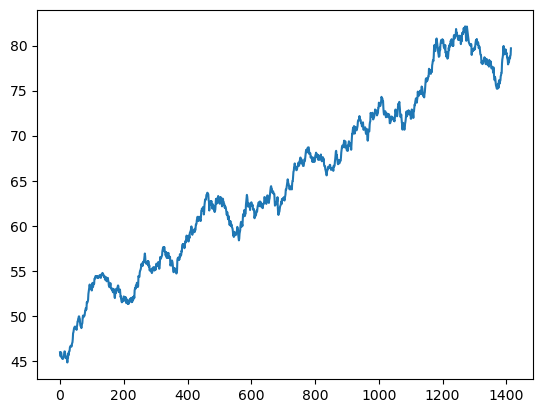

In [10]:
import matplotlib.pyplot as plt
import numpy as np
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')


plt.plot(smoothed_rewards)

## Visualize the policy


In [11]:
# Video generation does not yet work yet for me